# Estimating Income Quantiles from Block-group-level Census Data

For each trip, we only observe the drivers' census block, and the associated information about its income distribution—the percentage of residents whose household income falls in one of 8 bins.  We would like to be able to aggregate trips any way we would like, and then estimate the median income (or first quartile of income, etc.). Simply taking the mean of the median incomes of the census block groups does not work, as this notebook demonstrates.  Instead, we fit a Weibull distribution to the aggregated income distribution, and use it to calculate the desired quantities.  Previous research has identified the Weibull distribution as a relatively good two-parameter probability distribution for U.S. income.

In [100]:
suppressMessages(library(lubridate))
library(RSQLCipher)
library(stats4)
library(MASS)
suppressWarnings(library(VGAM))
suppressWarnings(suppressMessages(library(tidyverse)))

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6)

In [167]:
db_path = "../../../data/hot.db"

# import tables
acs = load_table(db_path, "acs") %>% execute
acs2 = read_csv("../../data/acs/block_group_estimates_transit_wide.csv")

trips.2pct = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute

Parsed with column specification:
cols(
  .default = col_double(),
  county_name = col_character(),
  county = col_character(),
  tract = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two.”Warning message:
“13 parsing failures.
  row col expected  actual         file
 7643 zip a double V3W7X4  literal data
45036 zip a double v7b1k7  literal data
58788 zip a double V6H 3W6 literal data
72041 zip a double V3W7X4  literal data
84177 zip a double V3W7X4  literal data
..... ... ........ ....... ............
See problems(...) for more details.
”

## Fitting a Weibull Distribution

We define the income bins used in our analysis, then write a function which takes in the bin boundaries and the count of trips/households falling within each bin.  These counts follow a multinomial distribution, so the function then finds the shape and scale parameters which minimize the negative log-likelihood of this multinomial likelihood. After, quantiles, means, and cumulative distribution functions are easily calculated, using `qweibull` and `pweibull`.

In [308]:
bins = c(0, 35, 50, 75, 100, 125, 150, 200, Inf)

get_weibull_pars = function(bins, counts) {
    n_bins = length(bins) - 1
    bins.l = bins[1:n_bins]
    bins.r = bins[2:(n_bins+1)]
    N = sum(counts)
    
    weibull_fit_obj = function(pars, counts) {
        y = (pweibull(bins.r, pars[1], pars[2]) - pweibull(bins.l, pars[1], pars[2]))
        y = if_else(y==0, 1e-99, y)
        -sum(counts * log(y))
    }
    
    fit = suppressWarnings(optim(c(5, mean(bins.l)), weibull_fit_obj, gr=NULL, counts, hessian=T))
    fit$N = N
    fit$counts = counts
    fit$bins = c(bins.l[1], bins.r)
    fit$bins.l = bins.l
    fit$bins.r = bins.r
    return(fit)
}

shape.inc = function(fit) fit$par[1]
scale.inc = function(fit) fit$par[2]
se.inc = function(fit) sqrt(abs(diag(solve(-fit$hessian))))

bin.pcts = function(fit) {
    pweibull(fit$bins.r, fit$par[1], fit$par[2]) - pweibull(fit$bins.l, fit$par[1], fit$par[2])
}

q.inc = function(q, bins, pct) {
    pars = get_weibull_pars(bins, pct)$par
    return(qweibull(q, pars[1], pars[2]))
}

p.inc = function(x, bins, pct) {
    pars = get_weibull_pars(bins, pct)$par
    return(pweibull(x, pars[1], pars[2]))
}

suits.idx = function(bins, pct) {
    pars = get_weibull_pars(bins, pct)$par
    2^(-1/pars[1]) - 1
}


median.se = function(bins, pct) {
    fit = get_weibull_pars(bins, pct)
    est.cov = abs(solve(-fit$hessian))
    N = 5e3
    pars = mvrnorm(N, fit$par, est.cov)
    medians = pars[,2] * log(2) ^ (1 / pars[,1])
    sd(medians)
}

mean.inc = function(bins, pct) {
    pars = get_weibull_pars(bins, pct)$par
    m = pars[2] * gamma(1 + 1/pars[1])
    names(m) = NULL
    return(m)
}

In [305]:
get_dagum_pars = function(bins, counts) {
    n_bins = length(bins) - 1
    bins.l = bins[1:n_bins]
    bins.r = bins[2:(n_bins+1)]
    N = sum(counts)
    
    dagum_fit_obj = function(pars, counts) {
        y = (pdagum(bins.r, pars[1], pars[2], pars[3]) - pdagum(bins.l, pars[1], pars[2], pars[3]))
        y = if_else(y==0, 1e-99, y)
        -sum(counts * log(y))
    }
    
    fit = suppressWarnings(optim(c(mean(bins.l), 1.5, 1.5), dagum_fit_obj, gr=NULL, counts, hessian=T))
    fit$N = N
    fit$counts = counts
    fit$bins = c(bins.l[1], bins.r)
    fit$bins.l = bins.l
    fit$bins.r = bins.r
    return(fit)
}

#shape1.inc = function(fit) fit$par[2]
#shape2.inc = function(fit) fit$par[3]
#scale.inc = function(fit) fit$par[1]
#se.inc = function(fit) sqrt(abs(diag(solve(-fit$hessian))))
#
bin.pcts.dagum = function(fit) {
    pdagum(fit$bins.r, fit$par[1], fit$par[2], fit$par[3]) - 
        pdagum(fit$bins.l, fit$par[1], fit$par[2], fit$par[3])
}
#
#q.inc = function(q, bins, pct) {
#    pars = get_dagum_pars(bins, pct)$par
#    return(qdagum(q, pars[1], pars[2], pars[3]))
#}
#
#p.inc = function(x, bins, pct) {
#    pars = get_dagum_pars(bins, pct)$par
#    return(pdagum(q, pars[1], pars[2], pars[3]))
#}
#
#suits.idx = function(bins, pct) {
#    pars = get_weibull_pars(bins, pct)$par
#    gamma(pars[3])*gamma(2*pars[3] + 1/pars[2]) / 
#        (gamma(2*pars[3])*gamma(pars[3] + 1/pars[2])) - 1
#}
#
#
#median.se = function(bins, pct) {
#    fit = get_dagum_pars(bins, pct)
#    est.cov = abs(solve(-fit$hessian))
#    N = 5e3
#    pars = mvrnorm(N, fit$par, est.cov)
#    medians = pars[,1] * (0.5^(-1/pars[,3] - 1))^(-1/pars[,2])
#    sd(medians)
#}
#
#mean.inc = function(bins, pct) {
#    pars = get_weibull_pars(bins, pct)$par
#    m = pars[2] * gamma(1 + 1/pars[1])
#    names(m) = NULL
#    return(m)
#}

### Testing the fit for census block groups

Unfortunately, individual census block groups have much more idiosyncratic income distributions, which are not well approximated by the Weibull distribution.

In [322]:
j = 101
trips.2pct[j,]
block.counts = (trips.2pct[j,] %>% select(starts_with("inc")) %>% as.numeric) * trips.2pct[j,]$population
fit = get_weibull_pars(bins, block.counts)

med.act = trips.2pct[j,]$med_inc
med.est = qweibull(0.5, shape.inc(fit), scale.inc(fit))
med.est
med.act
median.inc(bins, block.counts)
cat(paste0("Error in median estimation: ", round(100*(med.est*1000 - med.act)/med.act, 2), "%"))

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,population,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104029520,2694,0,1514910022,1514910696,5,12,1,6.103962e+17,-6.103609e+18,⋯,0.1532091,0.1221532,0.07039337,0,0.1511387,0.1532091,74779,1200,0.035,0.8908333


[1] 82.44532

[1] 74779

[1] 2.539684

Error in median estimation: 10.25%

In [314]:
j = 101
trips.2pct[j,]
block.counts = (trips.2pct[j,] %>% select(starts_with("inc")) %>% as.numeric) * trips.2pct[j,]$population
fit = get_dagum_pars(bins, block.counts)

med.act = trips.2pct[j,]$med_inc
med.est = qdagum(0.5, fit$par[1], fit$par[2], fit$par[3])
med.est
med.act
median.inc(bins, block.counts)
cat(paste0("Error in median estimation: ", round(100*(med.est*1000 - med.act)/med.act, 2), "%"))

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,population,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104029520,2694,0,1514910022,1514910696,5,12,1,6.103962e+17,-6.103609e+18,⋯,0.1532091,0.1221532,0.07039337,0,0.1511387,0.1532091,74779,1200,0.035,0.8908333


[1] 74.11007

[1] 74779

[1] 2.529117

Error in median estimation: -0.89%

Unfortunately, individual census block groups have much more idiosyncratic income distributions, which are not well approximated by the Weibull distribution.

In [326]:
j = 103:105
#trips.2pct[j,]
block.counts = trips.2pct[j,] %>% 
                mutate_at(vars(starts_with("inc")), ~ . * population) %>%
                select(starts_with("inc")) %>%
                summarize_all(sum) %>% as.numeric
fit = get_dagum_pars(bins, block.counts)

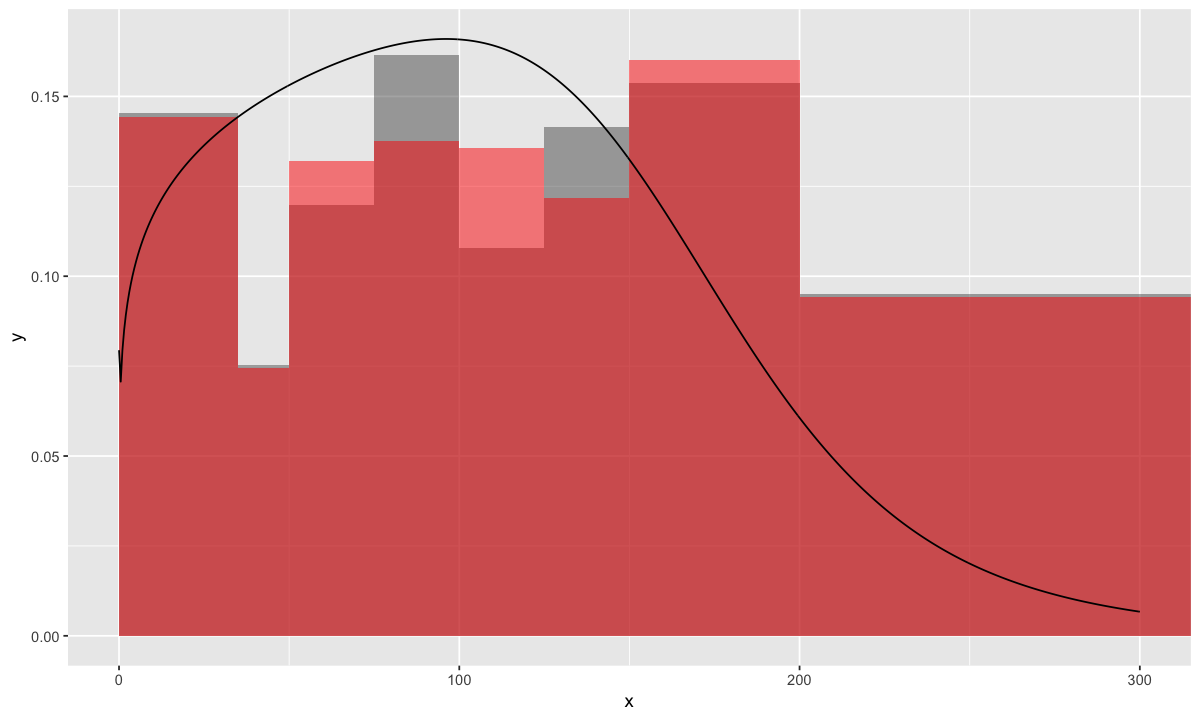

In [327]:
x = seq(0, 300, 0.5)
n_bins = length(bins) - 1
bins.l = bins[1:n_bins]
bins.r = bins[2:(n_bins+1)]
ggplot(tibble(l=bins.l, r=bins.r, p=block.counts/fit$N,
              pe=bin.pcts.dagum(fit)), 
       aes(xmin=l, xmax=r, ymin=0)) + 
    geom_rect(aes(ymax=p), alpha=0.5) + 
    geom_rect(aes(ymax=pe), fill="red", alpha=0.5) + 
    #annotate("line", x=x, y=30*dweibull(x, shape.inc(fit), scale.inc(fit)))
    annotate("line", x=x, y=30*ddagum(x, fit$par[1], fit$par[2], fit$par[3]))

# Estimating the fit for counties

In [328]:
acs %>%
    group_by(county_name) %>%
    mutate_at(vars(starts_with("inc")), ~ . * population) %>%
    select(county_name, starts_with("inc"), population) %>%
    summarize_all(sum, na.rm=T) %>%
    gather(inc_group, pct, -county_name, -population) %>%
    group_by(county_name) %>%
    summarize(est_050 = 1000 * q.inc(0.5, bins, pct),
              moe = 2 * 1000 * median.se(bins, pct),
              population = mean(population))  %>%
    mutate(act_050 = c(88466.4333902095, 70531.1935252691, 55123.8231153045, 
                       65517.3880763986, 60175.057225179, 81779.2169533977, 
                       68764.8310725574, 60028.0904553131, 46315.6837224804),
           act_acs_050 = c(83571, 68336, 53163, 63881, 59263, 78020, 66113, 56419, 47470),
           pct.error = (est_050 - act_acs_050)/act_acs_050)

# WEIBULL
#      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
#-0.0712626  0.0006844  0.0164027  0.0072421  0.0240300  0.0368449 

# DAGUM
#     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
#-0.051484 -0.001238  0.020376  0.012007  0.030280  0.037050 

county_name,est_050,moe,population,act_050,act_acs_050,pct.error
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
King,86247.50,111.9941,2118119,88466.43,83571,0.0320266331
Kitsap,69456.89,246.2120,258903,70531.19,68336,0.0164026951
Kittitas,49374.46,483.4661,43726,55123.82,53163,-0.0712626532
Pierce,66234.69,132.0905,845193,65517.39,63881,0.0368448564
Skagit,59303.56,330.0719,121725,60175.06,59263,0.0006843834
Snohomish,79894.82,153.1825,771904,81779.22,78020,0.0240299510
Thurston,67377.39,219.6816,269885,68764.83,66113,0.0191246782
Whatcom,57288.84,245.9651,212738,60028.09,56419,0.0154174248
Yakima,47085.99,187.5139,248279,46315.68,47470,-0.0080894420


## Trip aggregate distribution

In [82]:
bins.2 = c(0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 200, Inf)
n_bins = length(bins.2) - 1
bins.l = bins.2[1:n_bins]
bins.r = bins.2[2:(n_bins+1)]

counts = 4.89e6 * c(0.036928409, 0.020130219, 0.022249103, 0.024309668, 0.023299777, 
         0.026954918, 0.027248595, 0.029184255, 0.028827764, 0.061082813, 
         0.087823366, 0.13604567, 0.122984706, 0.090715132, 0.120352489, 0.141863116)

fit = get_weibull_pars(bins.2, counts)

paste("Est. median:", scales::dollar(1000*qweibull(0.5, fit$par[1], fit$par[2])))
paste("Bad median:", scales::dollar(mean(trips.2pct$med_inc, na.rm=T)))

[1] "Est. median: $94,605.11"

[1] "Bad median: $101,055"

In [329]:
x = seq(0, 300, 0.5)
ggplot(tibble(l=bins.l, r=bins.r, p=counts/sum(counts),  pe=bin.pcts(fit)), 
       aes(xmin=l, xmax=r, ymin=0)) + 
    geom_rect(aes(ymax=p), alpha=0.5) + 
    geom_rect(aes(ymax=pe), fill="red", alpha=0.5) + 
    annotate("line", x=x, y=30*dweibull(x, shape.inc(fit), scale.inc(fit)))

[1]  35  15  25  25  25  25  50 Inf

ERROR: Tibble columns must have consistent lengths, only values of length one are recycled:
* Length 8: Columns `l`, `r`, `pe`
* Length 16: Column `p`

## Estimating bin means
We can draw random samples from the fitted distribution to estimate the mean income within each bin, which allows us to calculate the total income of trips.

In [732]:
x = rweibull(1e7, fit$par[1], fit$par[2])
tibble(inc=x, bin=cut(x, c(bins.l, Inf))) %>%
    group_by(bin) %>%
    summarize(mean(inc))

bin,mean(inc)
<fct>,<dbl>
"(0,10]",5.783246
"(10,15]",12.556626
"(15,20]",17.536018
"(20,25]",22.522909
"(25,30]",27.520484
"(30,35]",32.508432
"(35,40]",37.501823
"(40,45]",42.502458
"(45,50]",47.500381


## Fare burden

In [219]:
shares = bind_rows(
    summarize_at(trips.2pct, vars(starts_with("inc")), ~ sum(., na.rm=T)),
    summarize_at(trips.2pct, vars(starts_with("inc")), ~ sum(. * toll, na.rm=T) / mean(toll)),
) %>%
mutate(share = c("trips", "fare")) %>%
gather(inc_group, pct, -share)

spread(shares, share, pct, sep="_") %>%
mutate_at(vars(starts_with("share")), round, 2)

inc_group,share_fare,share_trips
<chr>,<dbl>,<dbl>
inc_000_035k,23266.90,22826.29
inc_035_050k,13009.88,12689.56
inc_050_075k,22827.64,22184.94
inc_075_100k,20821.97,20252.61
inc_100_125k,18238.02,18358.39
inc_125_150k,13518.95,13528.73
inc_150_200k,17537.63,17959.16
inc_200_infk,19463.15,21156.32


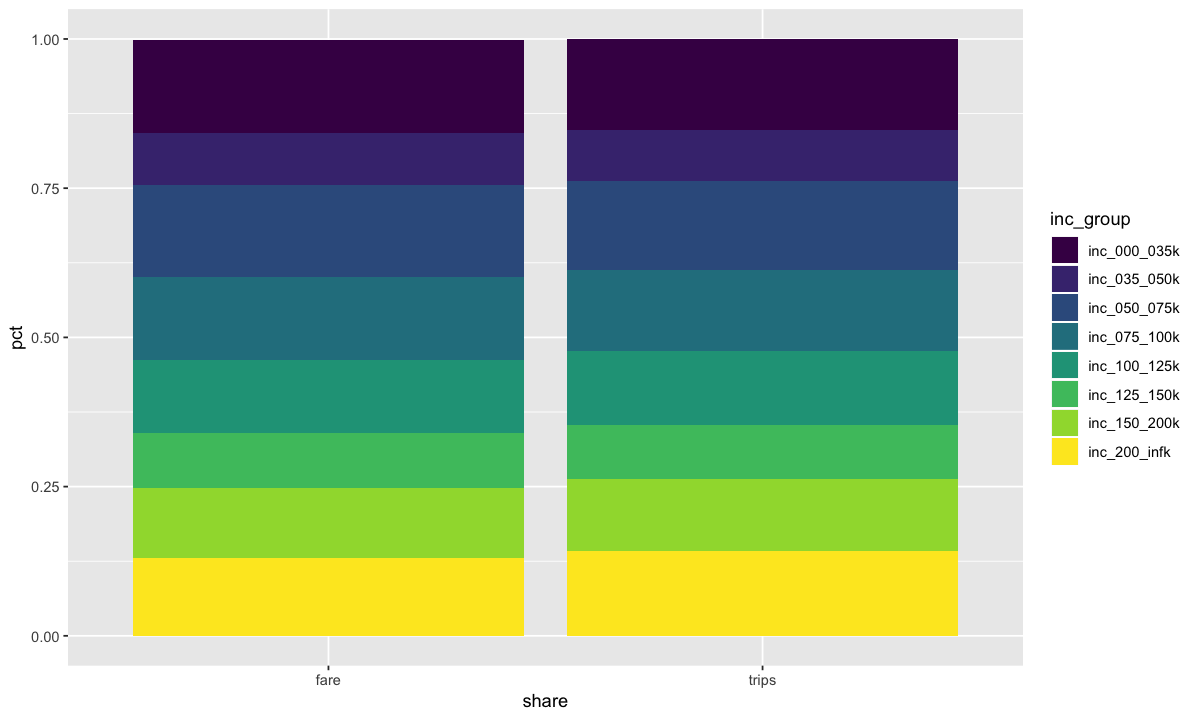

In [251]:
ggplot(shares, aes(share, pct, fill=inc_group)) + 
    geom_col() +
    scale_fill_viridis_d()

In [222]:
shares = spread(shares, share, pct, sep="_")
suits.idx(bins, shares$share_trips)
suits.idx(bins, shares$share_fare)

[1] -0.3873731

[1] -0.3852554

## "Travel Shed"

In [199]:
inc_shares_metro = acs %>% 
    filter(county_name == "King" | county_name == "Snohomish") %>%
    summarize_at(vars(starts_with("inc_")), ~ sum(. * population, na.rm=T)) %>%
    gather(inc_group, pct)

inc_shares_hot = trips.2pct %>%
    summarize_at(vars(starts_with("inc_")), mean, na.rm=T) %>%
    gather(inc_group, pct) %>%
    mutate(pct = pct * sum(!is.na(trips.2pct$med_inc)))

inc_shares = inc_shares_metro %>%
    transmute(inc_group = inc_group,
              pct_metro = pct,
              pct_hot = inc_shares_hot$pct)
inc_shares

suits.idx(bins, inc_shares$pct_metro)
suits.idx(bins, inc_shares$pct_hot)

qile_ests = inc_shares %>%
    summarize(est_010 = 1000*q.inc(0.1, bins, pct_metro),
              est_025 = 1000*q.inc(0.25, bins, pct_metro),
              est_050 = 1000*q.inc(0.5, bins, pct_metro),
              est_075 = 1000*q.inc(0.75, bins, pct_metro),
              est_090 = 1000*q.inc(0.9, bins, pct_metro))
qile_ests

metro_med = 1000 * q.inc(0.5, bins, inc_shares$pct_metro)

inc_group,pct_metro,pct_hot
<chr>,<dbl>,<dbl>
inc_000_035k,554514.1,19642.80
inc_035_050k,287722.5,11035.94
inc_050_075k,457839.0,19336.38
inc_075_100k,386088.6,17617.50
inc_100_125k,325462.9,16076.76
inc_125_150k,233494.3,11687.10
inc_150_200k,292568.8,15609.36
inc_200_infk,349942.7,17896.17


[1] -0.4107279

[1] -0.3852063

est_010,est_025,est_050,est_075,est_090
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20045.89,43138.98,84385.34,143202.7,210903.9


## Toll and Income (Again)

In [192]:
# We can also generate the data from a 2% sample of the trip file
inc_tolls = trips.2pct %>%
    filter(commercial == 0) %>%
    mutate(toll = ceiling(toll*2)/2) %>%
    group_by(toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.2pct %>% 
        filter(commercial == 0) %>%
        mutate(toll = ceiling(toll*2)/2) %>%
        group_by(toll) %>%
        summarize(count=n()),
        by="toll"
    )

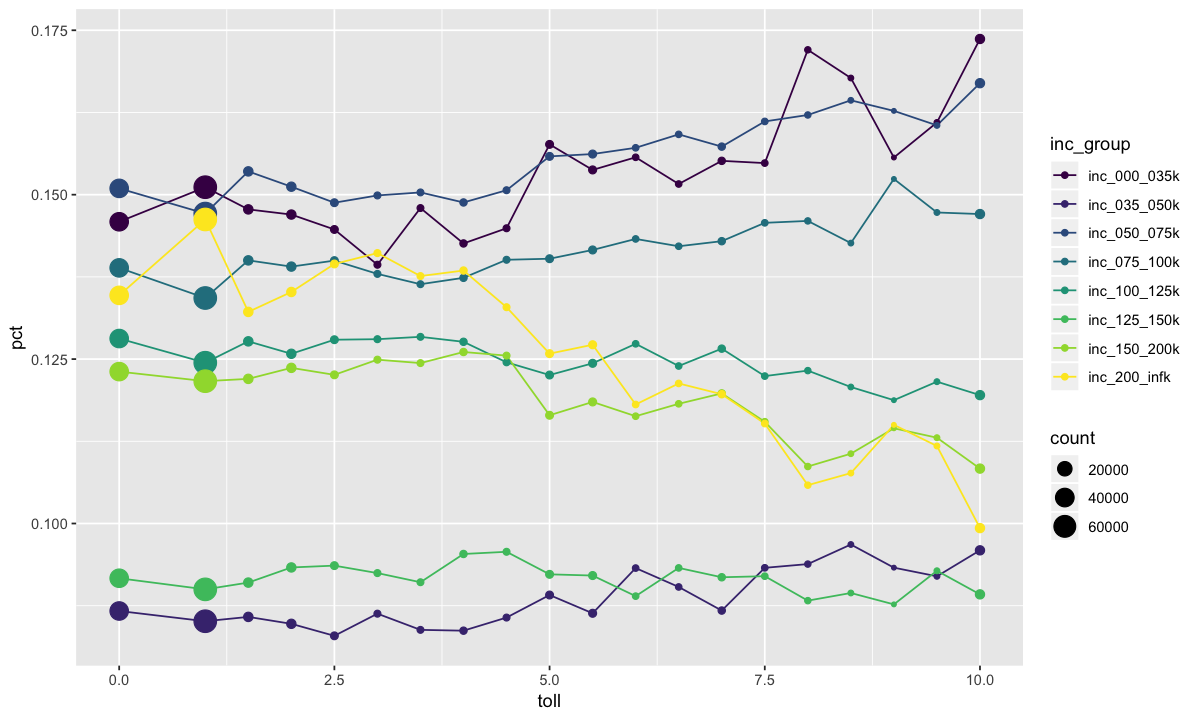

In [194]:
inc_tolls %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -toll, -count) %>%
    drop_na %>%
ggplot(aes(toll, pct, color=inc_group, group=inc_group)) +
    #geom_hline(aes(yintercept=pct, color=inc_group), data=inc_shares, alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) +
    scale_color_viridis_d()

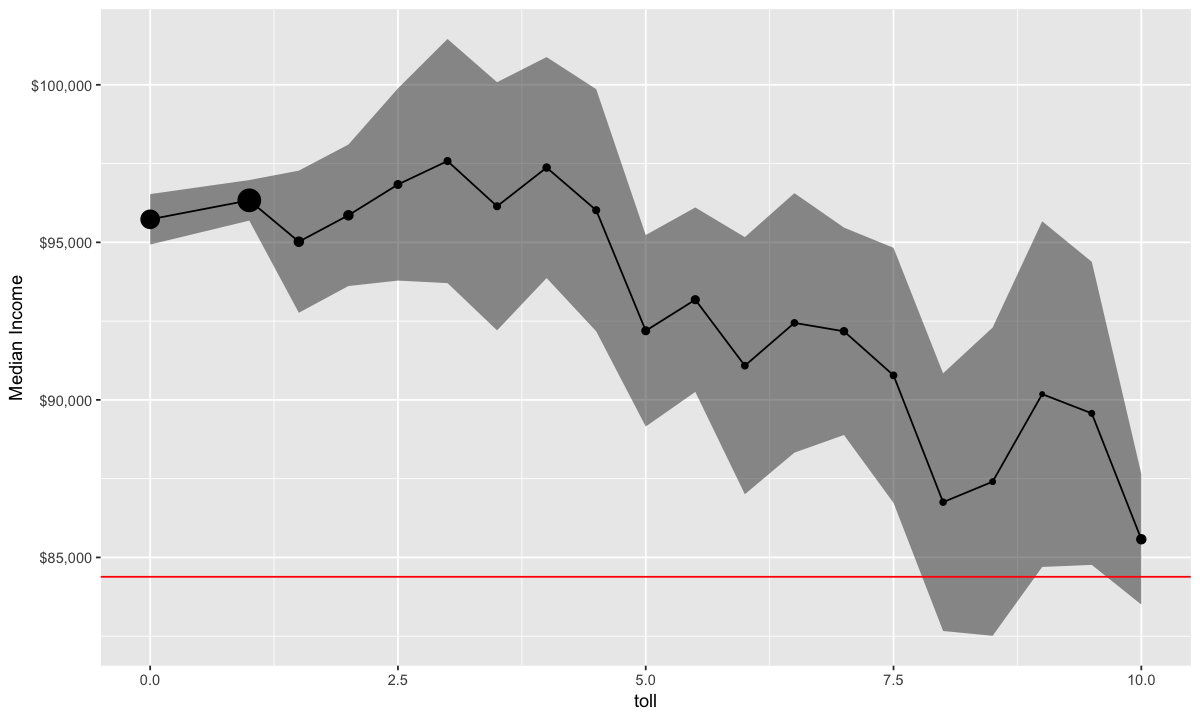

In [212]:
inc_tolls %>%
    drop_na %>%
    #select(-med_inc) %>%
    gather(inc_group, pct, -toll, -count, -med_inc) %>%
    arrange(toll, inc_group) %>%
    group_by(toll) %>%
    summarize(est_010 = 1000*q.inc(0.1, bins, pct*count),
              est_025 = 1000*q.inc(0.25, bins, pct*count),
              est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.se(bins, pct*count),
              est_075 = 1000*q.inc(0.75, bins, pct*count),
              est_090 = 1000*q.inc(0.9, bins, pct*count),
              med_inc_bad = mean(med_inc),
              count = mean(count)) %>%
ggplot(aes(toll, est_050)) + 
    #geom_line(aes(y=med_inc_bad), color="red") + 
    geom_ribbon(aes(ymin=est_050-2*med_se, ymax = est_050+2*med_se), alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) + 
    #geom_point(aes(y=med_inc_bad, size=count), color="red") + 
    #geom_smooth(method=lm, fill="blue", alpha=0.2) +
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    geom_hline(yintercept=metro_med, color="red") +
    guides(size=F)

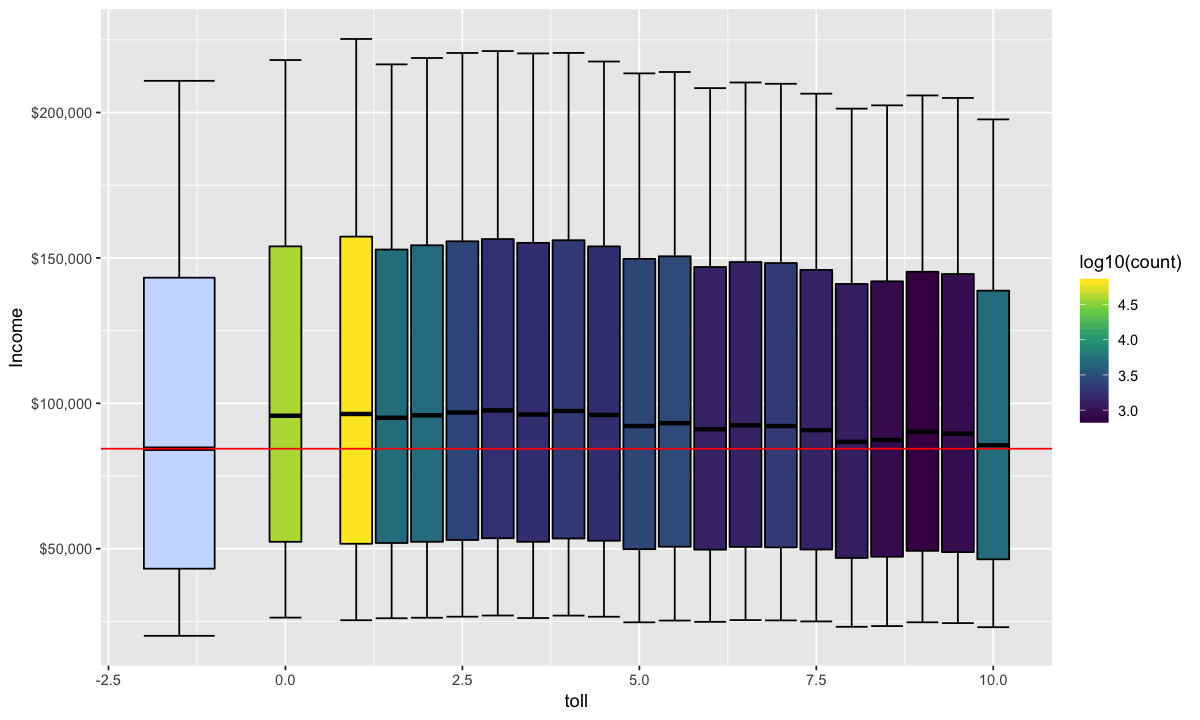

In [201]:
inc_tolls %>%
    drop_na %>%
    #select(-med_inc) %>%
    gather(inc_group, pct, -toll, -count, -med_inc) %>%
    arrange(toll, inc_group) %>%
    group_by(toll) %>%
    summarize(est_010 = 1000*q.inc(0.1, bins, pct*count),
              est_025 = 1000*q.inc(0.25, bins, pct*count),
              est_050 = 1000*q.inc(0.5, bins, pct*count),
              est_075 = 1000*q.inc(0.75, bins, pct*count),
              est_090 = 1000*q.inc(0.9, bins, pct*count),
              med_inc_bad = mean(med_inc),
              count = mean(count)) %>%
ggplot(aes(toll, est_050)) + 
    geom_errorbar(aes(ymin=est_010, ymax=est_090)) +
    geom_crossbar(aes(ymin=est_025, ymax=est_075, fill=log10(count))) +
    geom_errorbar(aes(x=-1.5, ymin=est_010, ymax=est_090), data=qile_ests, width=1.0) +
    geom_crossbar(aes(x=-1.5, y=est_050, ymin=est_025, ymax=est_075), data=qile_ests, fill="#ccddff", width=1.0) +
    scale_y_continuous(label=scales::dollar, name="Income") +
    geom_hline(yintercept=metro_med, color="red") +
    guides(size=F)

In [203]:
# We can also generate the data from a 2% sample of the trip file
inc_freq = trips.2pct %>%
    #filter(commercial == 0, is_hov == 0) %>%
    group_by(freq) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.2pct %>% 
    #    filter(commercial == 0, is_hov == 0) %>%
        group_by(freq) %>%
        summarize(count=n()),
        by="freq"
    )

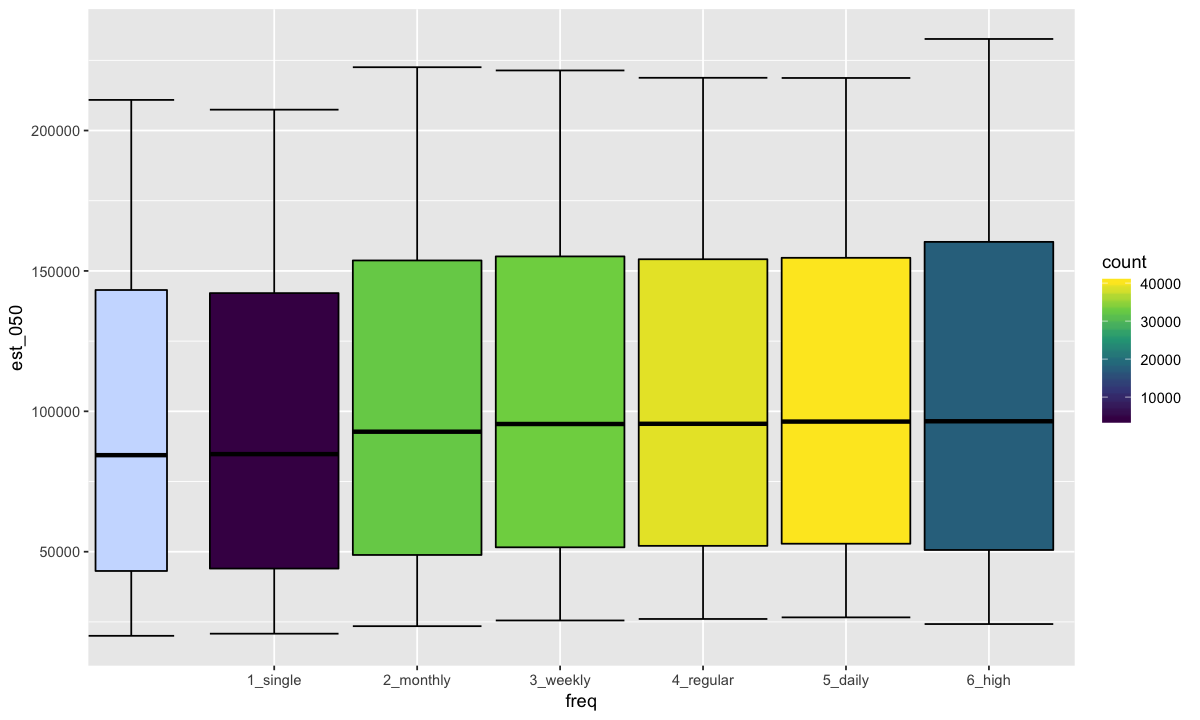

In [206]:
inc_freq %>%
    drop_na %>%
    gather(inc_group, pct, -freq, -count, -med_inc) %>%
    arrange(freq, inc_group) %>%
    group_by(freq) %>%
    summarize(est_010 = 1000*q.inc(0.1, bins, pct*count),
              est_025 = 1000*q.inc(0.25, bins, pct*count),
              est_050 = 1000*q.inc(0.5, bins, pct*count),
              est_075 = 1000*q.inc(0.75, bins, pct*count),
              est_090 = 1000*q.inc(0.9, bins, pct*count),
              count = mean(count)) %>%
ggplot(aes(freq, est_050)) + 
    geom_errorbar(aes(ymin=est_010, ymax=est_090)) +
    geom_crossbar(aes(ymin=est_025, ymax=est_075, fill=count)) +
    geom_errorbar(aes(x=0, ymin=est_010, ymax=est_090), data=qile_ests, width=0.6) +
    geom_crossbar(aes(x=0, y=est_050, ymin=est_025, ymax=est_075), data=qile_ests, fill="#ccddff", width=0.5) +
    guides(size=F)

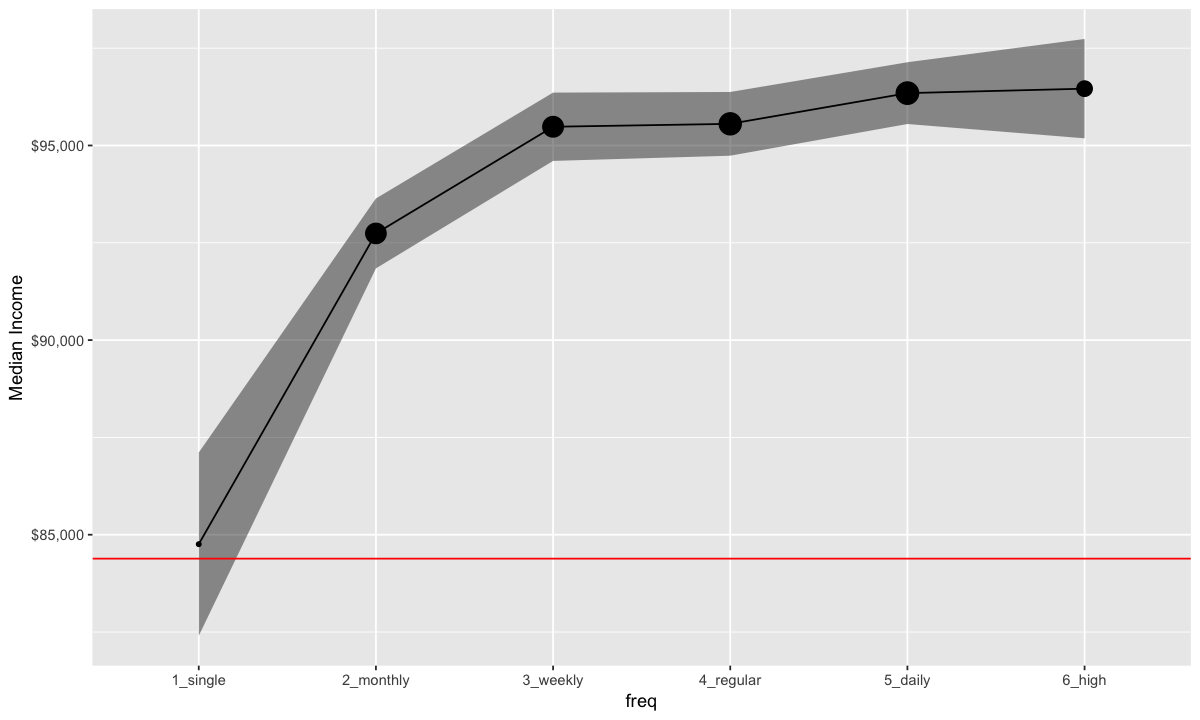

In [213]:
inc_freq %>%
    drop_na %>%
    gather(inc_group, pct, -freq, -count, -med_inc) %>%
    arrange(freq, inc_group) %>%
    group_by(freq) %>%
    summarize(est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.se(bins, pct*count),
              med_inc_bad = mean(med_inc),
              count = mean(count)) %>%
ggplot(aes(freq, est_050, group=1)) + 
    #geom_line(aes(y=med_inc_bad), color="red") + 
    geom_ribbon(aes(ymin=est_050-2*med_se, ymax = est_050+2*med_se), alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) + 
    #geom_point(aes(y=med_inc_bad, size=count), color="red") + 
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    geom_hline(yintercept=metro_med, color="red") +
    guides(size=F)

In [208]:
# We can also generate the data from a 2% sample of the trip file
inc_toll_freq = trips.2pct %>%
    filter(commercial == 0) %>%
    mutate(toll=ceiling(toll)) %>%
    group_by(toll, freq) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        trips.2pct %>% 
        filter(commercial == 0) %>%
        group_by(toll, freq) %>%
        summarize(count=n()),
        by=c("toll", "freq")
    )

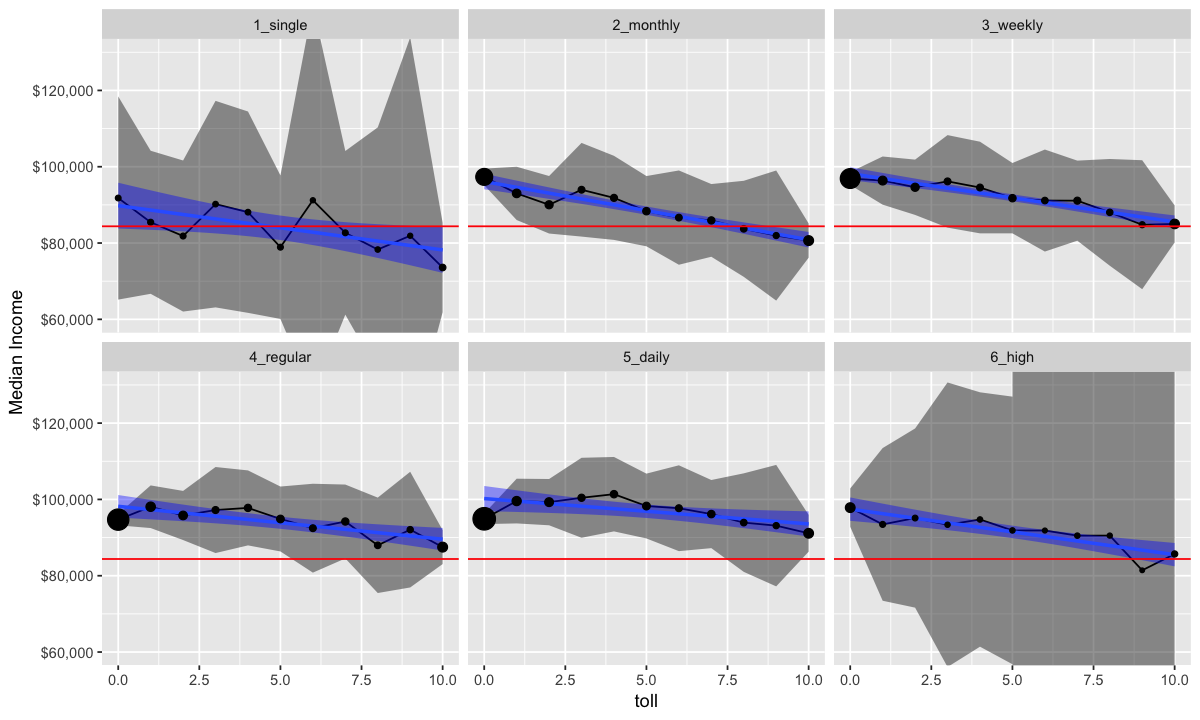

In [215]:
inc_toll_freq %>%
    drop_na %>%
    gather(inc_group, pct, -toll, -freq, -count, -med_inc) %>%
    arrange(toll, freq, inc_group) %>%
    group_by(toll, freq) %>%
    summarize(est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.se(bins, pct*count),
              med_inc_bad = mean(med_inc),
              count = mean(count)) %>%
ggplot(aes(toll, est_050)) + 
    facet_wrap("freq") +
    geom_ribbon(aes(ymin=est_050-2*med_se, ymax = est_050+2*med_se), alpha=0.5) +
    geom_line() + 
    geom_smooth(method=lm, fill="blue") + 
    geom_point(aes(size=count)) + 
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    coord_cartesian(ylim=c(60e3, 130e3)) + 
    geom_hline(yintercept=metro_med, color="red") +
    guides(size=F)

In [465]:
peak_data = trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           exit_time = as_datetime(exit_time),
           hour = hour(entry_time),
           direction = if_else(entry_plaza <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = if_else(direction == "SB", am_peak, pm_peak)) %>%
    select(-def_id, -entry_plaza, -exit_plaza, -tag_id, 
           -plate_state, -id, -zip, -fips, -population)

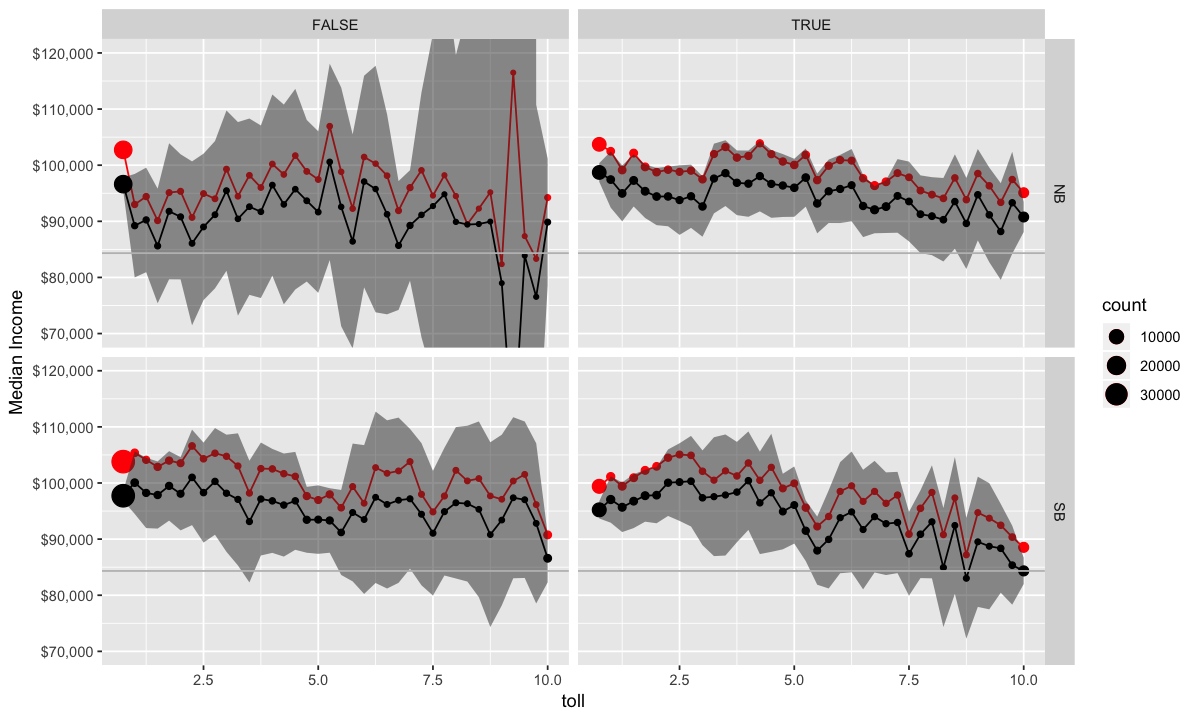

In [837]:
peak_data %>%
    drop_na %>%
    filter(commercial == 0, toll*4 == as.integer(toll*4)) %>%
    group_by(peak, direction, toll) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    left_join(
        peak_data %>% 
        drop_na %>%
        filter(commercial == 0) %>%
        group_by(peak, direction, toll) %>%
        summarize(count=n()),
        by=c("peak", "direction", "toll")
    ) %>%
    gather(inc_group, pct, -toll, -peak, -direction, -med_inc, -count) %>%
    arrange(peak, direction, toll, inc_group) %>%
    group_by(peak, direction, toll) %>%
    summarize(count=mean(count),
              est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.inc(bins, pct*count)$se,
              med_inc_bad = mean(med_inc)) %>%
ggplot(aes(toll, est_050)) + 
    facet_grid(direction ~ peak) +
    #geom_smooth(color="black", method=lm) +
    geom_point(aes(y=med_inc_bad, size=count), color="red") + 
    geom_line(aes(y=med_inc_bad, group=1), color="red") + 
    geom_ribbon(aes(ymin=est_050-2*med_se, ymax = est_050+2*med_se), alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) + 
    coord_cartesian(ylim=c(70e3, 120e3)) + 
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    geom_hline(yintercept=qile_ests$est_050, color="grey")# + 

In [216]:
plaza_dist = read_csv("../../data/milepost_lookups/plaza_dist.csv", col_types="cid")

In [217]:
mp_annotations = tribble(
    ~direction, ~mp, ~plaza, ~label,
    "NB", 0, 1, "Bellevue",
    "NB", 2.9, 3.1, "NE 70th",
    "NB", 5, 4, "NE 116th",
    "NB", 6.7, 6, "NE 128th DAR",
    "NB", 9.5, 7.3, "SR 522",
    "NB", 12.5, 8.2, "SR 527",
    "NB", 15.4, 10, "I-5",
    "SB", 0, 1, "I-5",
    "SB", 2, 2.4, "SR 527",
    "SB", 4.5, 3.5, "SR 522",
    "SB", 7.8, 7, "NE 128th DAR",
    "SB", 9.5, 7.8, "NE 85th",
    "SB", 13, 9.5, "SR 520",
    "SB", 14.9, 10, "Bellevue",
)

ann_nb = filter(mp_annotations, direction=="NB")
ann_sb = filter(mp_annotations, direction=="SB")

In [221]:
route_vols = trips.2pct %>%
    filter(commercial == 0, is_hov == 0) %>%
    group_by(entry_plaza, exit_plaza) %>%
    summarize_at(vars(starts_with("inc")), list(~ mean(. , na.rm=T), ~ n())) %>%
    select(entry=entry_plaza, exit=exit_plaza, volume=inc_000_035k_n, ends_with("_mean")) %>%
    ungroup() %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{entry}_{exit}")) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp) %>%
    gather(inc_group, pct, starts_with("inc_")) %>%
    arrange(direction, entry, exit, inc_group) %>%
    group_by(direction, entry, exit, id, entry_mp, exit_mp, trip_dist) %>%
    summarize(volume = mean(volume),
              est_010 = 1000*q.inc(0.1, bins, pct*volume),
              est_025 = 1000*q.inc(0.25, bins, pct*volume),
              est_050 = 1000*q.inc(0.5, bins, pct*volume),
              est_075 = 1000*q.inc(0.75, bins, pct*volume),
              est_090 = 1000*q.inc(0.9, bins, pct*volume),
              med_se = 1000*median.se(bins, pct*volume))
head(route_vols, 20)

direction,entry,exit,id,entry_mp,exit_mp,trip_dist,volume,est_010,est_025,est_050,est_075,est_090,med_se
<chr>,<dbl>,<dbl>,<glue>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NB,1,1,1_1,0.0,0.0,0.0,1374,23839.84,50720.25,98226.89,165381.6,242165.4,2436.033
NB,1,3,1_3,0.0,2.9,2.9,3111,27407.33,55341.21,102382.96,166273.4,237127.9,1575.640
NB,1,4,1_4,0.0,6.0,6.0,4891,27249.51,53797.61,97584.75,156037.8,220014.2,1129.220
NB,1,5,1_5,0.0,6.7,6.7,1511,28239.60,55989.62,101939.27,163479.1,231001.6,2171.912
NB,1,7,1_7,0.0,8.3,8.3,1479,27548.15,53568.70,95888.07,151728.8,212306.0,1959.087
NB,1,8,1_8,0.0,12.1,12.1,860,21549.51,43804.15,81513.52,132991.3,190303.1,2422.120
NB,1,9,1_9,0.0,14.3,14.3,127,18884.62,40416.71,78679.92,133014.0,195354.2,6429.244
NB,1,10,1_10,0.0,15.4,15.4,3199,22632.87,46002.16,85596.94,139644.7,199814.8,1286.432
NB,2,2,2_2,0.0,0.0,0.0,407,26503.07,56512.27,109657.84,184911.9,271068.4,4972.806


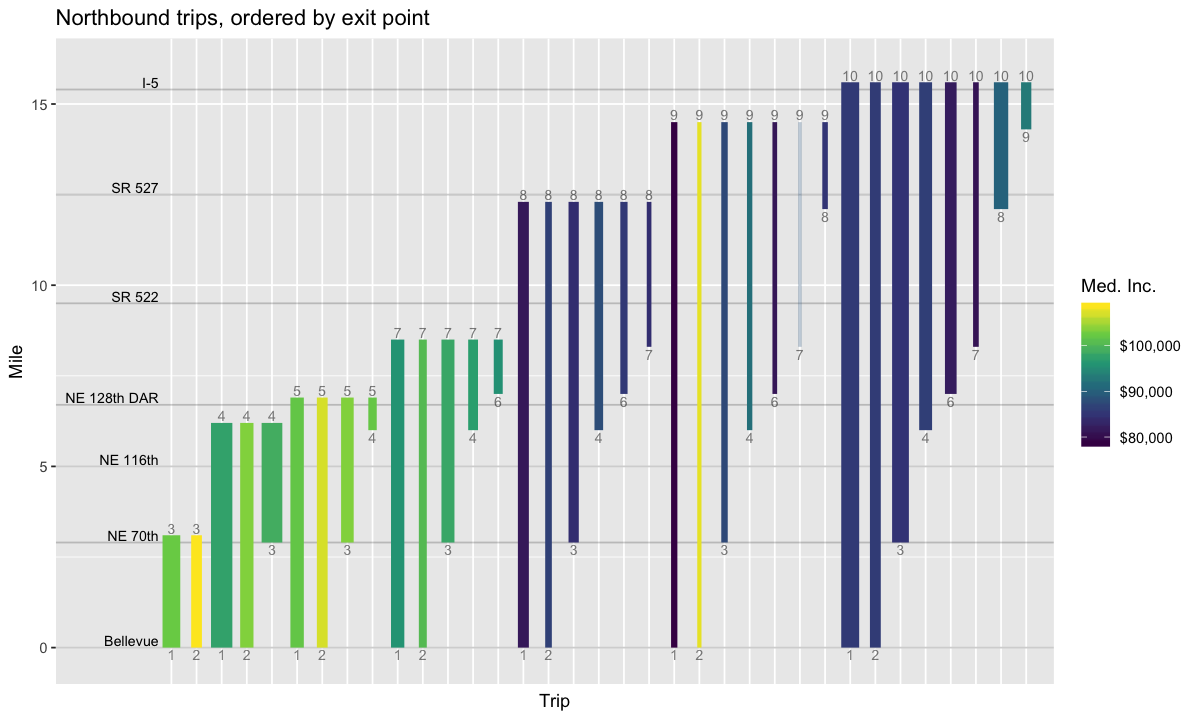

In [223]:
filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=est_050)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange(aes(alpha=-med_se)) + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar) + 
    scale_alpha(range=c(0.3,1)) +
    labs(title="Northbound trips, ordered by exit point", x="Trip", y="Mile", color="Med. Inc.")

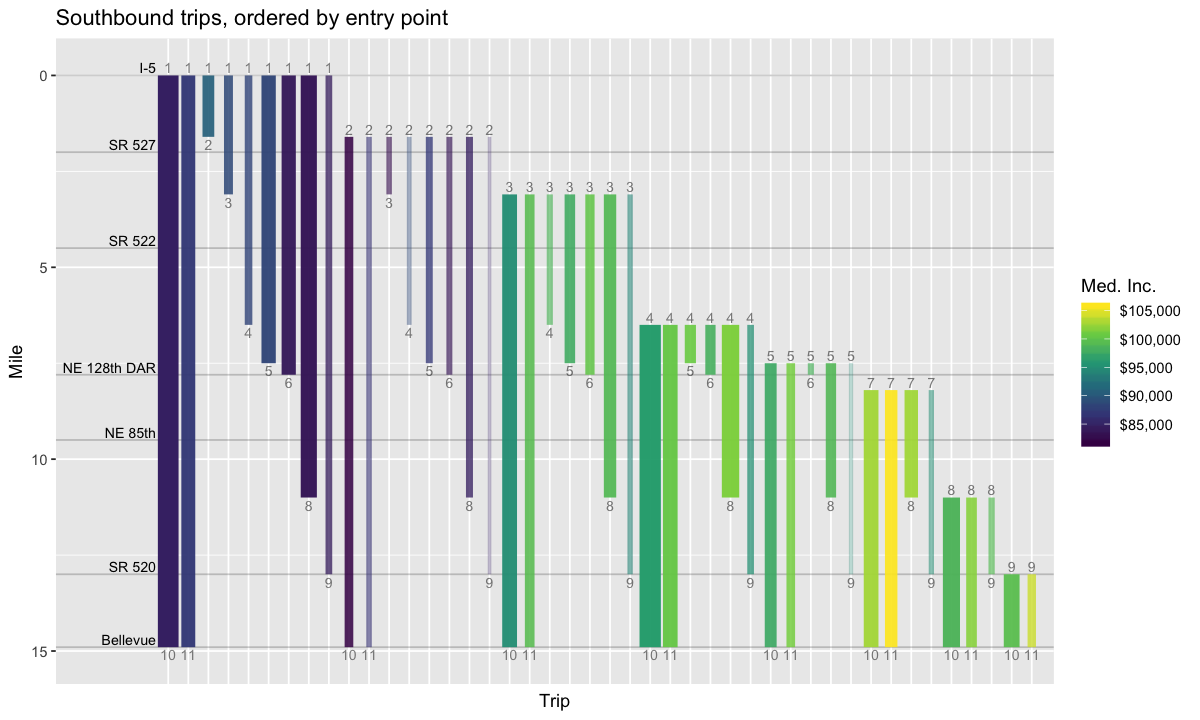

In [225]:
filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp, size=volume, color=est_050)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange(aes(alpha=-med_se)) + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar) + 
    scale_alpha(range=c(0.3,1)) +
    scale_y_reverse() +
    labs(title="Southbound trips, ordered by entry point", x="Trip", y="Mile", color="Med. Inc.")

In [226]:
head(trips.2pct)

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,med_inc,population,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104021794,2690,0.75,1514882240,1514882642,3,7,0,6.526634e+18,-3.507431e+18,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
104022592,2695,0.00,1514881397,1514881397,6,6,1,6.490796e+18,-3.173994e+18,⋯,0.1868512,0.07785467,0.05363322,0.06920415,0.2041522,0.34256055,154412,1517,0.20039552,0.7027027
104022598,2691,0.75,1514880508,1514880663,3,5,0,-6.006525e+18,-2.257406e+18,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
104022648,2689,0.00,1514884861,1514885735,3,12,1,2.742946e+17,7.091300e+04,⋯,0.1816239,0.08119658,0.12820513,0.03632479,0.1025641,0.17307692,76923,1005,0.26169154,0.4467662
104022870,2688,0.00,1514882453,1514883951,8,12,1,8.278127e+18,-8.094589e+18,⋯,0.2976501,0.06788512,0.02872063,0.07049608,0.1671018,0.12010444,70481,974,0.14168378,0.6899384
104023212,2697,0.75,1514884310,1514884482,10,12,0,-2.695963e+17,-9.192076e+18,⋯,0.1522911,0.07142857,0.16711590,0.01347709,0.0000000,0.04447439,33000,1532,0.07114883,0.6808094


In [284]:
inc_time_raw = trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           exit_time = as_datetime(exit_time),
           entry_hour = hour(entry_time) + round(minute(entry_time)/10)/6,
           exit_hour = hour(exit_time) + round(minute(exit_time)/10)/6) %>%
    filter(commercial == 0, is_hov == 0)

inc_time_E = inc_time_raw %>%
    mutate(hour = entry_hour) %>%
    group_by(hour) %>%
    summarize_at(vars(starts_with("inc")), mean, na.rm=T) %>%
    left_join(
        inc_time_raw %>%
        mutate(hour = entry_hour) %>%
        group_by(hour) %>%
        summarize(count=n()),
        by=c("hour")
    )
inc_time_X = inc_time_raw %>%
    mutate(hour = exit_hour) %>%
    group_by(hour) %>%
    summarize_at(vars(starts_with("inc")), mean, na.rm=T) %>%
    left_join(
        inc_time_raw %>%
        mutate(hour = entry_hour) %>%
        group_by(hour) %>%
        summarize(count=n()),
        by=c("hour")
    )


In [287]:
inc_time_E_plot = inc_time_E %>%
    gather(inc_group, pct, -hour, -count) %>%
    arrange(hour, inc_group) %>%
    group_by(hour) %>%
    summarize(est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.se(bins, pct*count),
              count = mean(count))

inc_time_X_plot = inc_time_X %>%
    gather(inc_group, pct, -hour, -count) %>%
    arrange(hour, inc_group) %>%
    group_by(hour) %>%
    summarize(est_050 = 1000*q.inc(0.5, bins, pct*count),
              med_se = 1000*median.se(bins, pct*count),
              count = mean(count))

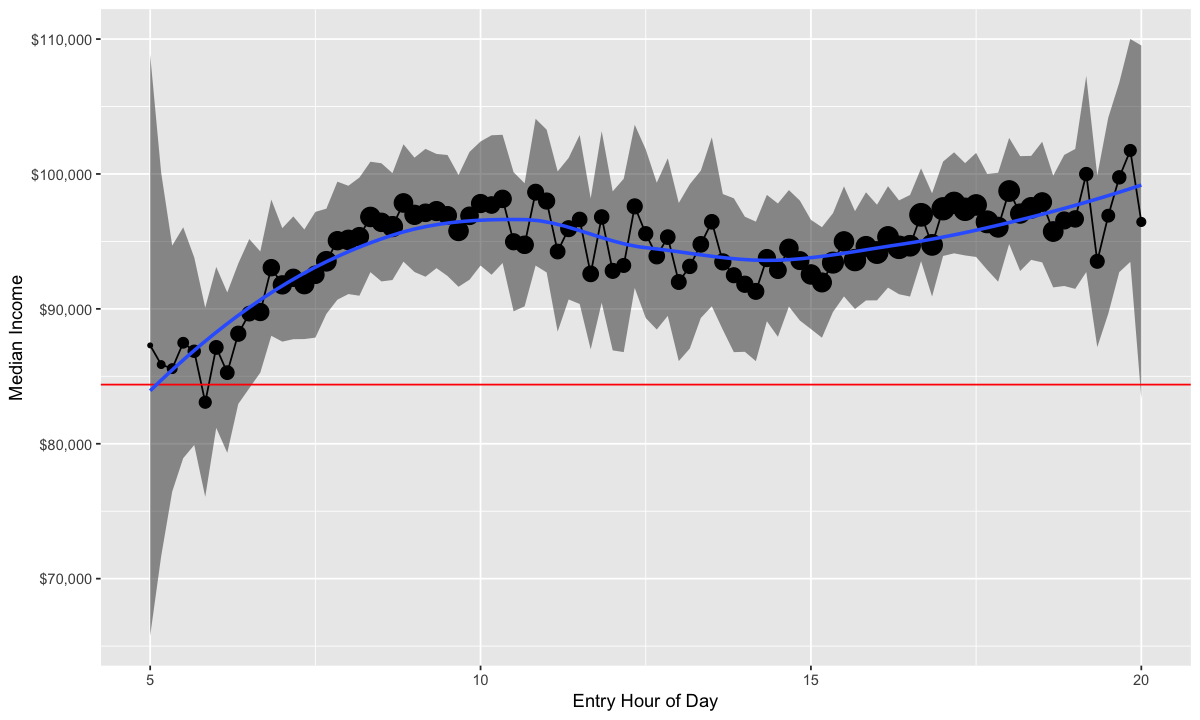

In [292]:
ggplot(inc_time_E_plot, aes(hour, est_050, group=1)) + 
    geom_ribbon(aes(ymin=est_050-2*med_se, ymax = est_050+2*med_se), alpha=0.5) +
    geom_line() + 
    geom_point(aes(size=count)) + 
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    geom_hline(yintercept=metro_med, color="red") +
    geom_smooth(se=F, method=loess) + 
    labs(x="Entry Hour of Day") +
    guides(size=F)

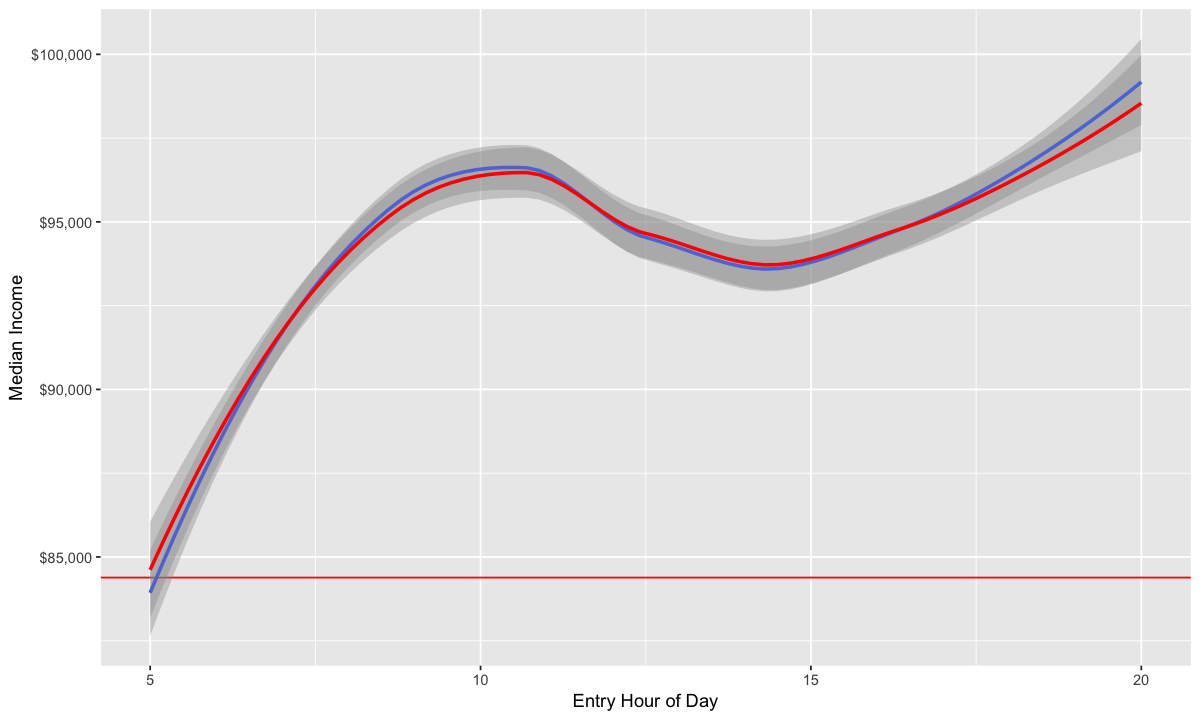

In [294]:
ggplot(inc_time_E_plot, aes(hour, est_050, group=1)) + 
    scale_y_continuous(label=scales::dollar, name="Median Income") +
    geom_hline(yintercept=metro_med, color="red") +
    geom_smooth(method=loess) + 
    geom_smooth(data=inc_time_X_plot, color="red", method=loess) + 
    labs(x="Entry Hour of Day") +
    guides(size=F)